# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, we'll train an image classifier to recognize different species of flowers. Imagine using something like this in a phone app that shows the name of the flower the camera is looking at. In practice, we'd train this classifier, then export it for use in other applications. We'll be using [dataset of 102 flower categories](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). See a few examples below.

<center><img src='assets/Flowers.png' width=500px></center>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on the dataset
* Use the trained classifier to predict image content

When completing this project, we will have an application that can be trained on any set of labeled images. For example, imagine an app where we take a picture of a car, it shows what the make and model is, then looks up information about it.

## Import packages

In [30]:
import os
from os import listdir
import json
import zipfile

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [54]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/My Drive/aipnd-project-master'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Extract the ZIP data
extract_dir = os.path.join(drive_path, 'flower_data_extracted')
zip_file_path = os.path.join(drive_path, 'flower_data.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## Load the data

Here we use [torchvision](https://pytorch.org/vision/stable/index.html) to load the data. The data should be included alongside this notebook, otherwise [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We'll also need to make sure the input data is resized to **224x224** pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.


In [46]:
data_dir = os.path.join(extract_dir, 'flower_data')  # Use the extracted directory as the data directory
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


In [47]:
print(f"train_dir: {train_dir}")
print(f"val_dir: {val_dir}")
print(f"test_dir: {test_dir}")


train_dir: /content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/train
val_dir: /content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/val
test_dir: /content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/test


In [48]:
# Print the files in the flower_data directory for validation
print("Files in flower_data directory:")
for file in os.listdir(data_dir):
    print(file)

Files in flower_data directory:
samples
test
train
val


In [49]:
# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

# Load the datasets with ImageFolder
train = datasets.ImageFolder(train_dir, transform=train_transforms)
val = datasets.ImageFolder(val_dir, transform=test_transforms)
test = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=64)
testloader = torch.utils.data.DataLoader(test, batch_size=64)

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which can be read in with the [`json` module](https://docs.python.org/3/library/json.html). This will provide a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [55]:
file_path = os.path.join(drive_path, 'cat_to_name.json')

with open(file_path, 'r') as f:
    cat_to_name = json.load(f)

## Build and train a classifier

Now that the data is ready, it's time to build and train the classifier. We will use one of [the pre-trained classification models](https://pytorch.org/vision/stable/models.html#classification) from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

### Load a pre-trained classification model

In [56]:
# Load a pre-trained model
model = models.vgg19(weights='DEFAULT')

# Freeze out the parameters of feature part
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 179MB/s]


### Define the classifier part of the model

In [57]:
n_input = model.classifier[0].in_features
n_output = len(cat_to_name)

# Modify classifier part
model.classifier = nn.Sequential(nn.Linear(n_input, 2048),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(512, n_output))

In [58]:
# Utilize GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cuda')

### Train the newly defined classifier part

In [59]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.classifier.parameters(), lr=.001)

epochs = 15
train_costs, val_costs = [], [None]

for i in range(epochs):
    sum_loss = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()

    # Print and save training costs
    train_costs.append(sum_loss / len(trainloader.dataset))
    print(f"Epoch: {i+1:2} -- Training cost (before epoch): {train_costs[-1]:.8f} -- ", end='')

    # Compute and save validation costs
    with torch.no_grad():
        model.eval()

        sum_loss = accuracy = 0
        for X, y in valloader:
            X, y = X.to(device), y.to(device)

            # Compute validation cost
            logits = model.forward(X)
            sum_loss += criterion(logits, y).item()

            # Compute validation accuracy
            y_hat = F.softmax(logits, dim=1)
            predictions = y_hat.argmax(dim=1)
            accuracy += (predictions == y).count_nonzero()

        val_costs.append(sum_loss / len(valloader.dataset))
        print(f"Validation cost (after epoch): {val_costs[-1]:.8f} -- ", end='')
        print(f"Validation accuracy: {accuracy.item()/len(valloader.dataset):.8f}")

        model.train()

Epoch:  1 -- Training cost (before epoch): 3.11059158 -- Validation cost (after epoch): 1.49808461 -- Validation accuracy: 0.59535452
Epoch:  2 -- Training cost (before epoch): 1.54721827 -- Validation cost (after epoch): 0.97743808 -- Validation accuracy: 0.72616137
Epoch:  3 -- Training cost (before epoch): 1.11855736 -- Validation cost (after epoch): 0.90163751 -- Validation accuracy: 0.75305623
Epoch:  4 -- Training cost (before epoch): 0.93814172 -- Validation cost (after epoch): 0.79479296 -- Validation accuracy: 0.78728606
Epoch:  5 -- Training cost (before epoch): 0.79795581 -- Validation cost (after epoch): 0.86521422 -- Validation accuracy: 0.75916870
Epoch:  6 -- Training cost (before epoch): 0.73535956 -- Validation cost (after epoch): 0.74603356 -- Validation accuracy: 0.79828851
Epoch:  7 -- Training cost (before epoch): 0.68290955 -- Validation cost (after epoch): 0.71573934 -- Validation accuracy: 0.79951100
Epoch:  8 -- Training cost (before epoch): 0.61544407 -- Valid

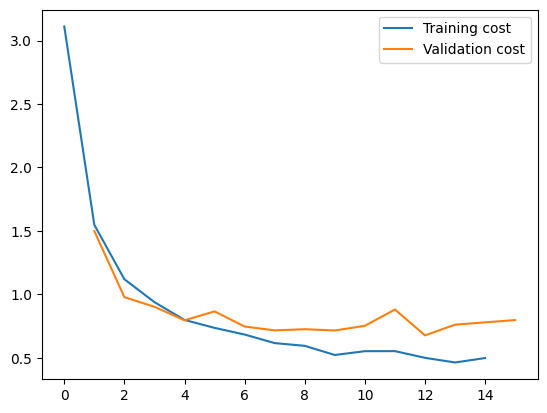

In [60]:
plt.plot(train_costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.legend()
plt.show()

## Test the model

It's good practice to test the trained neural network model on test data, images the network has never seen either in training or validation. This provides a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way we did validation. If the model has been trained well, it will be able to reach around **70%** accuracy on the test set.

In [69]:
from PIL import UnidentifiedImageError

accuracy = 0
with torch.no_grad():
    model.eval()

    for X, y in testloader:
        try:
            X, y = X.to(device), y.to(device)
            y_hat = F.softmax(model.forward(X), dim=1)
            predictions = y_hat.argmax(dim=1)
            accuracy += (predictions == y).count_nonzero()
        except UnidentifiedImageError as e:
            print(f"Skipping invalid image: {e}")
            continue  # Geçersiz resimleri atla

    model.train()

test_accuracy = accuracy.item() / len(testloader.dataset)
print('Testing accuracy:', test_accuracy)

UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/test/58/image_02722.jpg'>

file error ^

In [70]:
from PIL import Image, UnidentifiedImageError

# Custom Test ImageFolder class to handle invalid images
class CustomTestImageFolder(datasets.ImageFolder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, index):
        try:
            path, target = self.samples[index]
            sample = Image.open(path)  # Open the image
            sample = self.transform(sample)  # Apply transformations
            return sample, target
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping invalid image: {path} ({e})")
            # Skip invalid images and return the next valid image
            return self.__getitem__((index + 1) % len(self.samples))  # Get next image

# Use the CustomTestImageFolder for the test data
test = CustomTestImageFolder(test_dir, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test, batch_size=64)

# Testing phase
accuracy = 0
with torch.no_grad():
    model.eval()

    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        y_hat = F.softmax(model.forward(X), dim=1)
        predictions = y_hat.argmax(dim=1)
        accuracy += (predictions == y).count_nonzero()

    model.train()

test_accuracy = accuracy.item() / len(testloader.dataset)
print('Testing accuracy:', test_accuracy)


Skipping invalid image: /content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/test/58/image_02722.jpg (cannot identify image file '/content/drive/My Drive/aipnd-project-master/flower_data_extracted/flower_data/test/58/image_02722.jpg')
Testing accuracy: 0.796092796092796


## Save the checkpoint

Now that the model is trained, save it so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `train.class_to_idx`.

Remember that we'll completely rebuild the model later so we can use it for inference. If we want to load the model and keep training, we need to save the number of epochs as well as the optimizer state, `optimizer.state_dict()`.

In [71]:
checkpoint = {'n_class': model.classifier[-1].out_features,
              'epochs': epochs,
              'model': model.classifier.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx': train.class_to_idx,
              'test_accuracy': test_accuracy}

checkpoint_file = 'checkpoint.pth'
torch.save(checkpoint, checkpoint_file)

In [74]:
#Save to drive
checkpoint_file = os.path.join(drive_path, 'checkpoint.pth')
torch.save(checkpoint, checkpoint_file)

## Load the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to re-train the network.

In [75]:
def load_checkpoint(filename, verbose=True):
    # Load checkpoint
    checkpoint = torch.load(filename)

    # Load and adjust pre-trained model
    model = models.vgg19(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = False

    # Re-build classifier
    model.classifier = nn.Sequential(nn.Linear(model.classifier[0].in_features, 2048),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(2048, 512),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(512, checkpoint['n_class']))
    model.classifier.load_state_dict(checkpoint['model'])

    # Re-build optimizer
    optimizer = optim.Adam(model.classifier.parameters())
    optimizer.load_state_dict(checkpoint['optimizer'])

    if verbose:
        info = {'class_to_idx': checkpoint['class_to_idx'],
                'epochs': checkpoint['epochs'],
                'test_accuracy': checkpoint['test_accuracy']}
        return model, optimizer, info

    else:
        return model, optimizer

In [76]:
# Load saved model from checkpoint.pth
saved_model, optimizer, info = load_checkpoint(checkpoint_file)

<ipython-input-75-ae3170237754>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


## Inference for classification

### Image Preprocessing
First we'll need to handle processing the input image such that it can be used in our trained model.

We will use [`PIL`](https://pillow.readthedocs.io/en/latest/reference/Image.html) to load the image. It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is **256 pixels**, keeping the aspect ratio. Then crop out the center **224x224** portion of the image.

As before, the model expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`.

In [77]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Tensor array.
    '''

    # Process a PIL image for use in a PyTorch model
    img_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                        ])

    return img_transforms(image)

The function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [78]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        _, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.set_title(title)
    ax.spines[:].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    ax.imshow(image)

    return ax

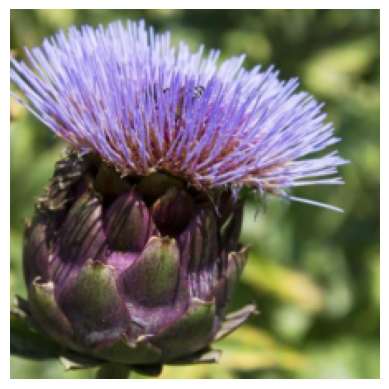

In [86]:
image_path = os.path.join(drive_path, 'flower_data_extracted', 'flower_data', 'samples', 'artichoke.jpg')
img = Image.open(image_path)
imshow(process_image(img))
plt.show()

### Class Prediction

It's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](https://pytorch.org/docs/stable/generated/torch.topk.html). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes.

Moreover, we need to convert from these indices to the actual class labels using `class_to_idx` which is loaded from the checkpoint. Make sure to invert the dictionary so we get a mapping from index to class as well.

This function takes a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [83]:
# Invert the dictionary to get a mapping from index to class
idx_to_class = {value: key for key, value in info['class_to_idx'].items()}

In [84]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Implement the code to predict the class from an image file
    # Utilize GPU when possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Load and pre-process image
    image = process_image(Image.open(image_path)).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        model.eval()
        y_hat = F.softmax(model.forward(image), dim=1)
        top_values, top_idx = y_hat.topk(topk, dim=1)
        model.train()

    # Convert neuron indices to classes
    top_classes = [idx_to_class[idx] for idx in top_idx[0].tolist()]

    return top_values[0].tolist(), top_classes

### Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We will convert the class integer encoding to actual flower names with the `cat_to_name.json` file loaded earlier in the notebook.

In [88]:
# Display an image along with the top 5 classes
k = 5
image_dir = os.path.join(drive_path, 'flower_data_extracted', 'flower_data', 'samples')
i = 0

for file in listdir(image_dir):
    if (file.endswith('.jpg') or file.endswith('.jpeg')) and file[0] != '.':
        img_path = os.path.join(image_dir, file)

        # Predict
        top_probs, top_classes = predict(img_path, saved_model, k)

        # Convert classes to actual label
        labels = [cat_to_name[cls] for cls in top_classes]

        # Show image
        plt.axes([0, i, .5, .5])
        plt.axis('off')
        plt.title(file.rsplit('.', 1)[0])
        plt.imshow(Image.open(img_path))

        # Show classification results
        plt.axes([.8, i, .75, .5])
        plt.axis('on')
        plt.title('Class Probability')
        plt.barh(labels, top_probs)
        plt.xlim(0, 1.1)

        i += 1

plt.show()

Output hidden; open in https://colab.research.google.com to view.